# ターボファンエンジンの診断システム構築

## 目的
- ターボファンエンジンの診断システムを構築する
    - システムの機能：
        - エンジンの現状把握（センサーデータの可視化）
        - 故障までのデータがない場合、異常検知手法も用いてエンジンの状態警告モデル
        - 故障までのデータがある場合、エンジンの状態を分類するモデル
        - 故障までのデータがある場合、エンジンの残存耐用期間（RUL）予測モデル

## このノートブックの目的
- 故障までのデータがある場合、エンジンの残存耐用期間（RUL）予測モデル
    - 精度向上するためにLSTMとCNN＋LSTMを用いてRUL予測モデルを構築する

## ノート

- Beside linear degradation model, we have `picewise linear` degradation model that is widely used in the case we know the threshold of RUL.
    - At the beginning, RUL is assigned to a fixed number (this is called early RUL).
    - When RUL value reaches early RUL, from there RUL follows a linear degradation model
- In this notebooks, we will use `picewise linear` model to add RUL values
- We assume that after 125 cycles, the maintaince will carry out, and the threashold for RUL is assigned to be 125.

## インポート

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error

import os
import gc
from pathlib import Path
# import warnings
# warnings.filterwarnings('ignore')

In [2]:
# pandasの設定
pd.set_option('display.max_columns',  50)
pd.set_option('display.max_rows', 100)

# 図の設定
mpl.rc('axes', titlesize=18)
mpl.rc('axes', labelsize=16)
mpl.rc('xtick', labelsize=16)
mpl.rc('ytick', labelsize=16)
mpl.rc('xtick', direction='in')
mpl.rc('ytick', direction='in')
mpl.rc('legend', fontsize=16)

# 色の設定
from cycler import cycler
import matplotlib.colors as mcolors
colors = mcolors.TABLEAU_COLORS
mpl.rcParams['axes.prop_cycle']  = cycler(color = [c for c in colors.values()])

## データ読み込み

In [3]:
# data path
data_dir = Path("../data/CMaps")
train_raw_dir = data_dir / "train_FD001.txt"
test_raw_dir = data_dir / "test_FD001.txt"
rul_raw_dir = data_dir / "RUL_FD001.txt"

In [4]:
# adding columns' name
variable_names = ['Unit','Time', 'setting_1', 'setting_2', 'setting_3',
                  'FanInletTemp', 'LPCOutletTemp', 'HPCOutletTemp', 
                  'LPTOutletTemp', 'FanInletPres', 'BypassDuctPres', 'TotalHPCOutletPres','PhysFanSpeed','PhysCoreSpeed', 
                  'EnginePresRatio', 'StaticHPCOutletPres', 'FuelFlowRatio', 'CorrFanSpeed', 'CorrCoreSpeed', 'BypassRatio',
                  'BurnerFuelAirRatio', 'BleedEnthalpy', 'DemandFanSpeed', 'DemandCorrFanSpeed', 'HPTCoolantBleed', 'LPTCoolantBleed']

In [5]:
# columns' group
index_names = ['Unit', 'Time']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = variable_names[5:]

In [6]:
train_df = pd.read_csv(train_raw_dir, 
                    sep='\s+', 
                    header=None,
                    index_col=False,
                    names=variable_names)
train = train_df.copy()

test_df = pd.read_csv(test_raw_dir, 
                    sep='\s+', 
                    header=None,
                    index_col=False,
                    names=variable_names)
test = test_df.copy()

y_test = pd.read_csv(rul_raw_dir, 
                     sep='\s+', 
                     header=None,
                     index_col=False,
                     names=['RUL'])

## Piecewise degradation RUL

In [7]:
engine_1_linear_degradation_model = np.arange(192-1, -1, -1)

# Piecewise_linear_degradation model
early_rul = 125
engine_1_piecewise_linear_degradation_model = np.append(early_rul * np.ones(shape=(192-early_rul)),
                                                        np.arange(early_rul-1, -1, -1))

print("Linear degradation model shape (for engine 1): ", engine_1_linear_degradation_model.shape)
print("Piecewise linear degradation model shape (for engine 1): ", engine_1_piecewise_linear_degradation_model.shape)

Linear degradation model shape (for engine 1):  (192,)
Piecewise linear degradation model shape (for engine 1):  (192,)


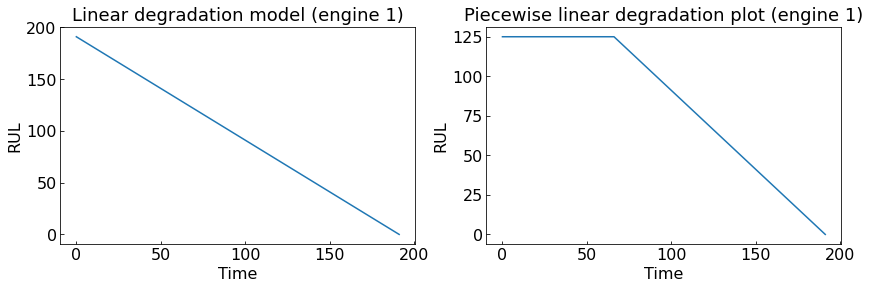

In [8]:
plt.figure(figsize = (14, 4))
plt.subplot(121)
plt.plot(engine_1_linear_degradation_model)
plt.title("Linear degradation model (engine 1)")
plt.ylabel("RUL")
plt.xlabel("Time")

plt.subplot(122)
plt.plot(engine_1_piecewise_linear_degradation_model)
plt.title("Piecewise linear degradation plot (engine 1)")
plt.ylabel("RUL")
plt.xlabel("Time")
plt.show()

### RUL算出

In [9]:
def process_targets(data_length, early_rul = None):
    """ 
    Takes datalength and earlyrul as input and 
    creates target rul.
    """
    if early_rul == None:
        return np.arange(data_length-1, -1, -1)
    else:
        early_rul_duration = data_length - early_rul
        if early_rul_duration <= 0:
            return np.arange(data_length-1, -1, -1)
        else:
            return np.append(early_rul*np.ones(shape = (early_rul_duration,)), np.arange(early_rul-1, -1, -1))

### LSTMためのデータを用意する

In [10]:
def process_input_data_with_targets(input_data, target_data=None, window_length=1, shift=1):

    num_batches = int(np.floor((len(input_data) - window_length)/shift)) + 1
    num_features = input_data.shape[1]
    output_data = np.repeat(np.nan, repeats = num_batches * window_length * num_features).\
                                    reshape(num_batches, window_length, num_features)
    if target_data is None:
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
        return output_data
    else:
        output_targets = np.repeat(np.nan, repeats = num_batches)
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
            output_targets[batch] = target_data[(shift*batch + (window_length-1))]
        return output_data, output_targets

In [11]:
def process_test_data(test_data_for_an_engine, window_length, shift, num_test_windows=1):
    max_num_test_batches = int(np.floor((len(test_data_for_an_engine) - window_length)/shift)) + 1

    if max_num_test_batches < num_test_windows:
        required_len = (max_num_test_batches -1)* shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        extracted_num_test_windows = max_num_test_batches
        return batched_test_data_for_an_engine, extracted_num_test_windows
    else:
        required_len = (num_test_windows - 1) * shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        extracted_num_test_windows = num_test_windows
        return batched_test_data_for_an_engine, extracted_num_test_windows

In [12]:
# create a backup
train_data = train.copy()
test_data = test.copy()

In [13]:
drop_indes = [0, 1,2,3,4,5,9,10,14,20,22,23]
drop_columns = [variable_names[i] for i in drop_indes]
selected_columns = [col for col in variable_names if col not in drop_columns]

In [14]:
len(selected_columns)

14

In [15]:
window_length = 30
shift = 1
early_rul = 125            
processed_train_data = []
processed_train_targets = []

num_test_windows = 1  
processed_test_data = []
num_test_windows_list = []

# scaling
scaler = StandardScaler()
scaler.fit(train_data[selected_columns])
train_data[selected_columns] = scaler.transform(train_data[selected_columns])
test_data[selected_columns] = scaler.transform(test_data[selected_columns])

train_data["Unit"] = train["Unit"]
test_data["Unit"] = test["Unit"]

num_train_machines = len(train_data["Unit"].unique())
num_test_machines = len(test_data["Unit"].unique())

# Process trianing data
for i in np.arange(1, num_train_machines + 1):
    temp_train_data = train_data[train_data["Unit"] == i].drop(columns=["Unit"]).values
    
    # Verify if data of given window length can be extracted from training data
    if (len(temp_train_data) < window_length):
        print("Train engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")
        
    temp_train_targets = process_targets(data_length=temp_train_data.shape[0], early_rul=early_rul)
    data_for_a_machine, targets_for_a_machine = process_input_data_with_targets(temp_train_data, temp_train_targets, 
                                                                                window_length=window_length, shift=shift)
    
    processed_train_data.append(data_for_a_machine)
    processed_train_targets.append(targets_for_a_machine)

processed_train_data = np.concatenate(processed_train_data)
processed_train_targets = np.concatenate(processed_train_targets)

# Process test data
for i in np.arange(1, num_test_machines + 1):
    temp_test_data = test_data[test_data["Unit"] == i].drop(columns=["Unit"]).values
    
    # Verify if data of given window length can be extracted from test data
    if (len(temp_test_data) < window_length):
        print("Test engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")
    
    # Prepare test data
    test_data_for_an_engine, num_windows = process_test_data(temp_test_data, window_length = window_length, shift = shift,
                                                             num_test_windows = num_test_windows)
    
    processed_test_data.append(test_data_for_an_engine)
    num_test_windows_list.append(num_windows)

processed_test_data = np.concatenate(processed_test_data)
true_rul = y_test.iloc[:,0].values

# Shuffle training data
index = np.random.permutation(len(processed_train_targets))
processed_train_data, processed_train_targets = processed_train_data[index], processed_train_targets[index]

In [16]:
print(processed_train_data.shape)
print(processed_train_targets.shape)
print(processed_test_data.shape)
print(true_rul.shape)

(17731, 30, 25)
(17731,)
(100, 30, 25)
(100,)


In [17]:
processed_train_data, processed_val_data, processed_train_targets, processed_val_targets = train_test_split(processed_train_data,
                                                                                                            processed_train_targets,
                                                                                                            test_size = 0.2,
                                                                                                            random_state = 83)
print("Processed train data shape: ", processed_train_data.shape)
print("Processed validation data shape: ", processed_val_data.shape)
print("Processed train targets shape: ", processed_train_targets.shape)
print("Processed validation targets shape: ", processed_val_targets.shape)

Processed train data shape:  (14184, 30, 25)
Processed validation data shape:  (3547, 30, 25)
Processed train targets shape:  (14184,)
Processed validation targets shape:  (3547,)


## LSTM モデル

In [18]:
from keras import regularizers
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Flatten

def create_LSTM_model(l1_nodes, l2_nodes, d1_nodes, d2_nodes, input_shape):
    
    # input layer
    lstm1 = LSTM(l1_nodes, input_shape=input_shape, return_sequences=True, 
                 kernel_regularizer=regularizers.l2(0.1))
    do1 = Dropout(0.2)
    
    lstm2 = LSTM(l2_nodes, return_sequences=True, 
                 kernel_regularizer=regularizers.l2(0.1))
    do2 = Dropout(0.2)
    
    flatten = Flatten()
    
    dense1 = Dense(d1_nodes, activation='relu', kernel_regularizer=regularizers.l2(0.1))
    do3 = Dropout(0.2)
    
    dense2 = Dense(d2_nodes, activation='relu', kernel_regularizer=regularizers.l2(0.1))
    do4 = Dropout(0.2)
    
    # output layer
    outL = Dense(1, activation='relu', kernel_regularizer=regularizers.l2(0.1))
    # combine the layers
    layers = [lstm1, lstm2, do2, flatten,  dense1, dense2, outL]
    
    # create the model
    model = Sequential(layers)
    model.compile(optimizer='adam', loss='mse')
    
    return model

In [19]:
import tensorflow as tf
def scheduler(epoch):
    if epoch < 5:
        return 0.001
    else:
        return 0.0001
callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)

In [20]:
# create model
model = create_LSTM_model(64, 64, 64, 8, (window_length, 25))

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            23040     
                                                                 
 lstm_1 (LSTM)               (None, 30, 64)            33024     
                                                                 
 dropout_1 (Dropout)         (None, 30, 64)            0         
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                                                                 
 dense (Dense)               (None, 64)                122944    
                                                                 
 dense_1 (Dense)             (None, 8)                 520       
                                                                 
 dense_2 (Dense)             (None, 1)                 9

In [22]:
history = model.fit(processed_train_data, processed_train_targets, epochs=10,
                    validation_data=(processed_val_data, processed_val_targets),
                    callbacks=callback,
                    batch_size=128, verbose =2)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10


2022-08-22 11:54:57.277166: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


111/111 - 6s - loss: 1807.6763 - val_loss: 742.5359 - lr: 0.0010 - 6s/epoch - 52ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/10
111/111 - 5s - loss: 676.8445 - val_loss: 668.4769 - lr: 0.0010 - 5s/epoch - 42ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/10
111/111 - 5s - loss: 566.4725 - val_loss: 459.5804 - lr: 0.0010 - 5s/epoch - 42ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/10
111/111 - 5s - loss: 453.0344 - val_loss: 581.6946 - lr: 0.0010 - 5s/epoch - 42ms/step

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/10
111/111 - 5s - loss: 417.6620 - val_loss: 514.2194 - lr: 0.0010 - 5s/epoch - 43ms/step

Epoch 6: LearningRateScheduler setting learning rate to 0.0001.
Epoch 6/10
111/111 - 5s - loss: 347.9988 - val_loss: 323.5152 - lr: 1.0000e-04 - 5s/epoch - 44ms/step

Epoch 7: LearningRateScheduler setting learning rate to 0.0001.
Epoch 7/10
111/111 - 5s - loss: 

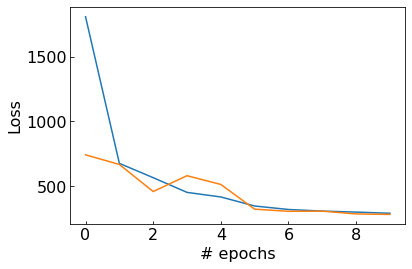

In [23]:
n_epochs = 10
plt.plot(np.arange(n_epochs), history.history['loss'], label='Train Loss')
plt.plot(np.arange(n_epochs), history.history['val_loss'], label='Val Loss')
plt.xlabel("# epochs")
plt.ylabel("Loss");

In [24]:
rul_pred = model.predict(processed_test_data).reshape(-1)
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows)) 
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
print("RMSE: ", RMSE)

4/4 [==============================] - 0s 4ms/step
RMSE:  17.74493196748517


In [25]:
indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine)[indices_of_last_examples]

In [26]:
RMSE_new = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))
print("RMSE (Taking only last examples): ", RMSE_new)

RMSE (Taking only last examples):  17.74493196748517


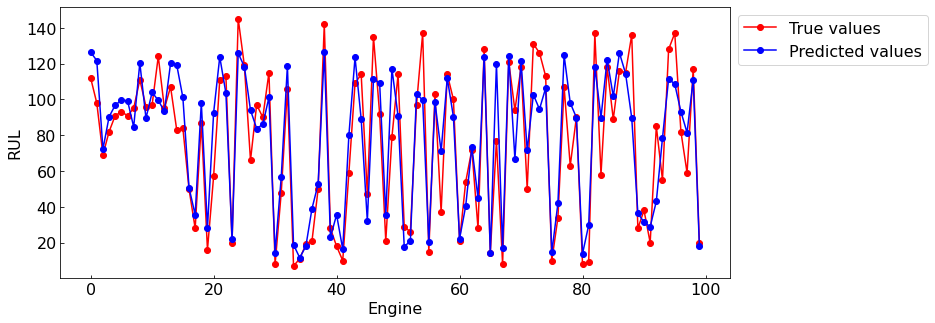

In [27]:
# Plot true and predicted RUL values
plt.figure(figsize=(12, 5))
plt.plot(true_rul, "r-o", label="True values")
plt.plot(preds_for_last_example, "b-o", label="Predicted values")
plt.xlabel("Engine")
plt.ylabel("RUL")
plt.legend(bbox_to_anchor=(1,1));

## CNN + LSTM

In [28]:
from keras.models import Sequential
from keras.layers import Convolution1D
from keras.layers import MaxPooling1D
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Dropout

In [29]:
def create_CNN_LSTM_model(input_shape):
    
    cv1 = Convolution1D(input_shape=input_shape, filters=18, kernel_size=2, strides=1, padding='same', activation='relu', name='cv1')
    mp1 = MaxPooling1D(pool_size=2, strides=2, padding='same', name = 'mp1')
    
    cv2 = Convolution1D(filters=36, kernel_size=2, strides=1, padding='same', activation='relu', name='cv2')
    mp2 = MaxPooling1D(pool_size=2, strides=2, padding='same', name= 'mp2')
    
    cv3 = Convolution1D(filters=72, kernel_size=2, strides=1, padding='same', activation='relu', name='cv3')
    mp3 = MaxPooling1D(pool_size=2, strides=2, padding='same', name= 'mp3')
    
    d4 = Dense(input_shape[0]*input_shape[1], activation='relu')
    do4 = Dropout(0.2)
    
    lstm5 = LSTM(input_shape[1]*3, return_sequences=True)
    do5 = Dropout(0.2)
    
    lstm6 = LSTM(input_shape[1]*3)
    do6 = Dropout(0.2)
    
    d7 = Dense(50, activation='relu')
    do7 = Dropout(0.2)
    
    dout = Dense(1)
    
    model = Sequential([cv1, mp1, cv2, mp2, cv3, mp3, d4, do4, lstm5, do5, lstm6, do6, d7, do7, dout])
    model.compile(optimizer='rmsprop', loss='mse')
    return model

In [30]:
model_CNN_LSTM = create_CNN_LSTM_model((30, 25))

In [31]:
model_CNN_LSTM.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cv1 (Conv1D)                (None, 30, 18)            918       
                                                                 
 mp1 (MaxPooling1D)          (None, 15, 18)            0         
                                                                 
 cv2 (Conv1D)                (None, 15, 36)            1332      
                                                                 
 mp2 (MaxPooling1D)          (None, 8, 36)             0         
                                                                 
 cv3 (Conv1D)                (None, 8, 72)             5256      
                                                                 
 mp3 (MaxPooling1D)          (None, 4, 72)             0         
                                                                 
 dense_3 (Dense)             (None, 4, 750)           

In [32]:
history_CNN_LSTC = model_CNN_LSTM.fit(processed_train_data, processed_train_targets, epochs=10,
                    validation_data=(processed_val_data, processed_val_targets),
                    callbacks=callback,
                    batch_size=128, verbose =2)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10
111/111 - 3s - loss: 3978.5867 - val_loss: 1852.0356 - lr: 0.0010 - 3s/epoch - 29ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/10
111/111 - 2s - loss: 1852.5653 - val_loss: 1771.3546 - lr: 0.0010 - 2s/epoch - 17ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/10
111/111 - 2s - loss: 1835.9117 - val_loss: 1770.7050 - lr: 0.0010 - 2s/epoch - 18ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/10
111/111 - 2s - loss: 1716.3334 - val_loss: 1497.8899 - lr: 0.0010 - 2s/epoch - 18ms/step

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/10
111/111 - 2s - loss: 1146.7966 - val_loss: 822.4323 - lr: 0.0010 - 2s/epoch - 18ms/step

Epoch 6: LearningRateScheduler setting learning rate to 0.0001.
Epoch 6/10
111/111 - 2s - loss: 861.0611 - val_loss: 746.5897 - lr: 1.0000e-04 - 2s/epoch - 17ms/step

Epoch 7: Lear

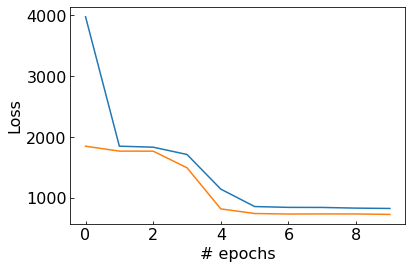

In [33]:
n_epochs = 10
plt.plot(np.arange(n_epochs), history_CNN_LSTC.history['loss'], label='Train Loss')
plt.plot(np.arange(n_epochs), history_CNN_LSTC.history['val_loss'], label='Val Loss')
plt.xlabel("# epochs")
plt.ylabel("Loss");

In [34]:
rul_pred = model_CNN_LSTM.predict(processed_test_data).reshape(-1)
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows)) 
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
print("RMSE: ", RMSE)

4/4 [==============================] - 0s 2ms/step
RMSE:  30.566231924687358


In [35]:
indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine)[indices_of_last_examples]

In [36]:
RMSE_new = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))
print("RMSE (Taking only last examples): ", RMSE_new)

RMSE (Taking only last examples):  30.566231924687358


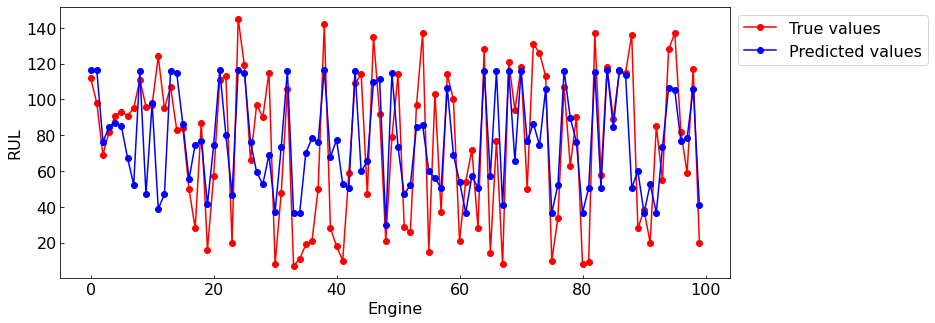

In [37]:
# Plot true and predicted RUL values
plt.figure(figsize=(12, 5))
plt.plot(true_rul, "r-o", label="True values")
plt.plot(preds_for_last_example, "b-o", label="Predicted values")
plt.xlabel("Engine")
plt.ylabel("RUL")
plt.legend(bbox_to_anchor=(1,1));